Assignment 12: Radial Basis Function Network
============================================


Microsoft Forms Document: https://forms.office.com/r/Zyre1SxphD


In our experiments we will apply this layer as the prior-to-last layer in our classification network, and try to learn two-dimensional deep feature representations for the MNIST dataset that are able to classify the digits into 10 different classes.

We will use three different parameters here:

* $K$ is the dimensionality of the deep features that feed into the RBF layer. We will use $K=2$ in out experiments to be able to visualize the computed feature space.
* $R$ is the number of basis functions, i.e., the output dimension of the RBF layer.
* $O$ is the number of outputs. Since we will work with MNIST, $O=10$ in our experiments.


Task 1: Dataset
---------------

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation set.

In [1]:
import torch
import torchvision

# training set and data loader
train_set = torchvision.datasets.MNIST(
  root=".",
  train=True,
  download=True,
  transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(
  root=".",
  train=False,
  download=True,
  transform=torchvision.transforms.ToTensor()
)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=False, batch_size=32)

device = torch.device("cuda")

Task 2: Radial Basis Function Layer
-----------------------------------
Implement the RBF layer as a `torch.nn.Module`.
In `__init__`, store the weight matrix (aka. the basis functions) as a `torch.nn.Parameter`, and initialize them randomly with values in range $[-2,2]$.
In `forward`, compute and return the distances of the input to all *basis functions*, i.e., vectors stored in out weight matrix.

In [2]:
class RBFLayer(torch.nn.Module):
  def __init__(self, K, R):
    # call base class constructor
    super(RBFLayer, self).__init__()
    # store a parameter for the basis functions
    self.W = torch.nn.Parameter(torch.empty((R,K)))
    # initialize the matrix between -2 and 2
    torch.nn.init.uniform_(self.W, -2, 2)

  def forward(self, x):
    # collect the required shape parameters, B, R, K
    B, R, K = x.shape[0], self.W.shape[0], x.shape[1]
    # Bring the weight matrix of shape R,K to size B,R,K by adding batch dimension (B, dim 0)
    W = self.W.unsqueeze(0).expand((B,R,K))
    # Bring the input matrix of shape B,K to size B,R,K by adding R dimension (dim=1)
    X = x.unsqueeze(dim=1).expand((B,R,K))
    # compute the activation
    A = (W-X)**2
    return torch.sum(A,dim=2)

Task 3: Radial Basis Function Activation
----------------------------------------
The activation function also requires a `Parameter`, i.e., the standard deviations of the Gaussian.
Hence, we need to implement the activation function also as a `torch.nn.Module`.
Here, we are treating the denominator of the Gaussian as a separate variable: `sigma2 = 2*sigma*sigma`.

Implement the activation function with learnable `sigma2` parameters.
Initialize all `sigma2` parameters with the value of 1.

In [3]:
class RBFActivation(torch.nn.Module):
  def __init__(self, R):
    # call base class constructor
    super(RBFActivation, self).__init__()
    self.R=R
    # store a parameter for the basis functions
    self.sigma2 = torch.nn.Parameter(torch.ones(R))

  def forward(self, x):
    # implement the RBF activation function
    return torch.exp(-x/self.sigma2)

Test 1: RBF Layer and Activation
--------------------------------

Instantiate an RBF layer and an RBF activation function for $K=4$ and $R=10$.
Generate a random batch of size $B=12$.
Call both the RBF layer and the activation on the batch.
Make sure that the resulting output is of shape $B\times K$.

In [4]:
# instantiate layer and activation
test_layer = RBFLayer(4, 10)
test_activation = RBFActivation(10)
# create test data batch
test_data = torch.ones( (12, 4) )

# forward test data through the layer and the activation
a = test_layer.forward(test_data)
h = test_activation.forward(a)

# check that the shape is correct
assert(a.shape==(12,10))
assert(h.shape==(12,10))

Task 4: Radial Basis Function Network
-------------------------------------

As the network, we rely on our convolutional network from Assignment 8.
However, this time we add an RBF layer and its activation between the first and the second fully-connected layer.
We will return both the deep features of dimension $K$ and the logits of dimension $O$.
Note that the processing will happen on batch level.

In [5]:
class RBFNetwork(torch.nn.Module):
  def __init__(self, Q1, Q2, K, R, O):
   # call base class constrcutor
    super(RBFNetwork,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=Q1,kernel_size=5,stride=1,padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1,out_channels=Q2,kernel_size=5,stride=1,padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)
    self.act = torch.nn.ReLU()
    # define first fully-connected layer
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(7*7*Q2, K, bias=True)
    # define RBF layer and its activation
    self.rbf_layer = RBFLayer(K,R)
    self.rbf_activation = RBFActivation(R)
    # define second fully-connected layer
    self.fc2 = torch.nn.Linear(R, O, bias=False)

  def forward(self,x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.act(x)
    x = self.flatten(x)
    # get the deep feature layer as the output of the first fully-connected layer
    deep_feature = self.fc1(x)
    # apply the RBF layer and activation
    rbf = self.rbf_layer(deep_feature)
    rbf = self.rbf_activation(rbf)
    # apply the last fully-connected layer to obtain the logits
    logits = self.fc2(rbf)
    # return both the logits and the deep features
    return logits, deep_feature

Task 5: Training and Validation Loop
------------------------------------

The training and validation loop is as usual.
Instantiate the network with $Q_1=32$, $Q_2=64$, $K=2$, $R=100$ and $O=10$.
Instantiate loss function and optimizer.
Train the network on the training set.
Compute the validation set accuracy after each epoch of training.

Hint: The validation set accuracy after the first epoch should be more than 80%. 
If it is much lower, increase the learning rate and/or change the optimizer.
On the other hand, should the accuracy get stuck around 10% and does not change over the epochs, reduce the learning rate.

In [6]:
network = RBFNetwork(32,64,2,100,10)
optimizer = torch.optim.Adam(network.parameters(), lr=0.0005)
loss = torch.nn.CrossEntropyLoss()
network.to(device)

for epoch in range(20):
  for x,t in train_loader:
    # train network with the current batch
    optimizer.zero_grad()
    logits, deep_feature = network(x.to(device))
    J = loss(logits.to(device), t.to(device))
    J.backward()
    optimizer.step()

  # compute validation set accuracy
  correct = 0
  with torch.no_grad():
    for x,t in validation_loader:
      # compute accuracy for current batch
      y, _ = network(x.to(device))
      correct += torch.count_nonzero(t.to(device) == torch.argmax(y, dim=1)).item()

  ## 96%
  print(F"Epoch {epoch+1}; test accuracy: {correct/(len(validation_set)):1.4f}")

Epoch 1; test accuracy: 0.9306
Epoch 2; test accuracy: 0.9438
Epoch 3; test accuracy: 0.9551
Epoch 4; test accuracy: 0.9591
Epoch 5; test accuracy: 0.9638
Epoch 6; test accuracy: 0.9629
Epoch 7; test accuracy: 0.9689
Epoch 8; test accuracy: 0.9670
Epoch 9; test accuracy: 0.9650
Epoch 10; test accuracy: 0.9650
Epoch 11; test accuracy: 0.9615
Epoch 12; test accuracy: 0.9620
Epoch 13; test accuracy: 0.9658
Epoch 14; test accuracy: 0.9651
Epoch 15; test accuracy: 0.9672
Epoch 16; test accuracy: 0.9649
Epoch 17; test accuracy: 0.9652
Epoch 18; test accuracy: 0.9677
Epoch 19; test accuracy: 0.9670
Epoch 20; test accuracy: 0.9666


Task 6: Deep Feature Extraction
-------------------------------

Extract the deep feature representations from the validation set.
Separate them by target class.


In [7]:
import numpy

# extract all deep features for all validation set samples
features = [[] for _ in range(10)]

with torch.no_grad():
  for x,t in validation_loader:
    # extract deep features
    _, feature = network(x.to(device))
    # separate the 10 different targets into separate lists
    for i, targ in enumerate(t):
      features[targ].append(numpy.array(feature[i].cpu()))

# convert features to numpy for later processing/plotting
features = [numpy.array(f[:]) for f in features]

Task 7: Deep Feature Visualization
----------------------------------

Obtain a list of 10 distinct colors.
Plot a dot for each in the 2-D space, maybe using `pyplot.scatter`.
Plot these dots with a different color for each class.

Task 8: Basis Function Visualization
------------------------------------

Obtain the learned basis functions $\vec w_r$ and their according sizes $\sigma_r$ from the trained network.
Draw black circles centered at $\vec w_r$ and with radii corresponding to $\sigma_r$ on top of the deep feature plot.
Note that the `s=` parameter to the `scatter` function is given in pts.

Note: Since each notebook cell uses its own drawing process, we need to combine Tasks 7 and 8 here.

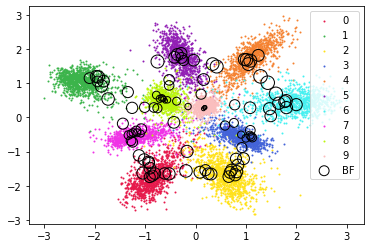

In [8]:
from matplotlib import pyplot

# define 10 visually distinct colors
colors = numpy.array([
    [230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [67, 99, 216],
    [245, 130, 49],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [188, 246, 12],
    [250, 190, 190],
]) / 255.


# generate 10 scatter plots, one for each label
for i in range(10):
  pyplot.scatter(features[i][:,0],features[i][:,1],s=1,color=colors[i],label=F'{i}')

# get the basis functions from the rbf layer
basis_functions = network.rbf_layer.W.to("cpu").detach().numpy()
# get the basis functions from the rbf activation
sigmas = network.rbf_activation.sigma2.to("cpu").detach().numpy()

# plot learned centers
pyplot.scatter(basis_functions[:,0], basis_functions[:,1], color="k", marker="o", s=sigmas*100, facecolors="none", label="BF")

# make the plot more beatuiful
pyplot.legend()